 **Kurze Erklärung zum Programm**

# Markowitz (Mean-Variance) Model

--- 

Hier stelle ich kurz das Grundliegende Model der Portfoliotheorie vor: Das Markowitz Model


Wenn die Schwankung der täglichen Renditen verschiedener Aktien ungefähr Normal verteilt ist, kann man die Gewichtung so kombinieren das die Schwankung des Portfolios kleiner ist als die Schwakung der einzelnen Titel ("Minimumvarianzprinzip")

---




In [31]:
# Hier im ersten Block werden Libraries für die Berechnung des Portfolios importiert 

import decimal
import pandas as pd
import numpy as np
import cvxopt as opt
from cvxopt import blas, solvers
import quandl
import matplotlib.pyplot as plt
# API configuration here
quandl.ApiConfig.api_key = "VAA5bZ67DimoDkvMStuG"
solvers.options['show_progress'] = False
import matplotlib.pyplot as plt

In [32]:
# Hier werden die Aktien oder Anleihen in einer Liste geladen
# stocks1 und stocks2 list muss klar unterschieden werden

stocks1 = ['AMD', 'NVDA', 'OKE', 'CHK', 'NEM', 'AMAT', 'ALB', 'FCX', 'HPE', 'IDXX', 'WMB']

'''
stocks1 = ['AMD', 'NVDA', 'OKE', 'CHK', 'NEM', 'AMAT', 'ALB', 'FCX', 'HPE', 'IDXX', 'WMB',
        'DHR', 'WYNN', 'PWR', 'ALGN', 'MU', 'CHTR', 'AVGO', 'CMA', 'NAVI', 'NUE', 'DLR', 'CNP', 'SYMC', 'RF',
        'MCHP', 'SYY', 'LRCX', 'FMC', 'ROST', 'TWX', 'MLM', 'STX', 'UNH', 'VTR', 'DRE', 'DGX', 'PLD', 'HP',
        'UAL', 'GLW', 'KEY', 'BBY', 'DE', 'CMI', 'WM', 'MGM', 'SNI', 'CFG', 'ZION', 'HAL', 'RSG', 'DRI', 'PKG']
'''

# A list of riskier stocks, (could be any other asset) to restrict the weights specifically

stocks2 = ['TIVO', 'JCP', 'F'] # ['AAPL']


In [33]:
# Hier werden die Preise von der Quandl Datenbank gezogen

def datafunction(tickers):
    data = quandl.get_table('WIKI/PRICES', ticker = tickers, 
                            qopts = { 'columns': ['ticker', 'date', 'adj_close'] },
                            date = { 'gte': '2016-12-31', 'lte': '2017-12-31' }, 
                            paginate=True)
    new = data.set_index('date')
    # use pandas pivot function to sort adj_close by tickers
    clean_data = new.pivot(columns='ticker')
    return clean_data

stocklist = stocks1 + stocks2
#print(stocklist)


clean_data = datafunction(stocklist)

print(clean_data)


             adj_close                                                         \
ticker             ALB       AMAT      AMD   CHK          F    FCX        HPE   
date                                                                            
2017-01-03   87.310827  31.708608  11.4300  6.92  11.923135  13.78  22.930139   
2017-01-04   89.938580  32.006435  11.4300  7.00  12.472414  14.83  23.177231   
2017-01-05   89.631183  31.867449  11.2400  7.18  12.093601  14.62  23.285951   
2017-01-06   90.047657  31.807884  11.3200  7.01  12.084131  14.90  22.831302   
2017-01-09   89.720427  32.542523  11.4900  6.87  11.961016  14.68  22.297583   
2017-01-10   89.125464  32.889987  11.4400  6.92  12.169364  15.55  22.683047   
2017-01-11   92.516753  33.227524  11.2000  6.92  11.998898  15.87  22.495257   
2017-01-12   92.962976  33.068683  10.7600  6.93  11.923135  15.27  22.485373   
2017-01-13   93.210877  33.545206  10.5800  6.92  11.961016  15.19  22.673163   
2017-01-17   93.557939  33.0


## In der nächsten Zeile können Sie die Modellparameter bestimmen 

---

**Wichtig ist das man das Maixmalgewicht nicht unterschreitet, da sonst die Gewichte in keinem Fall auf 100% kommen können und das das Programm eine Fehlermeldung wiedergibt**

Generell sollte das minimale und maximale Gewicht pro Wertpapier zwischen -1.0 und 1.0 liegen (-100% und 100%) 

---



In [34]:
# hier kann man die Modelparameter anpassen:

#Gewichtung im Model
Minimal_gewicht1 = -0.0
Maximal_gewicht1 = 0.1

Minimal_gewicht2 = 0.05
Maximal_gewicht2 = 0.15

Scale = 100 #usually set to 100
Riskaversion = 99 #have to figure out how to make it proportional to the Scale 

rf = 0.01 #risk-free rate for assets 

data_start = 2016-12-31
data_end = 2017-12-31


x = decimal.Decimal(100/len(stocklist))
print("Achtung! das Maximale Gewicht (Maximal_gewicht) darf ", round(x,3) , "% nicht unterschreiten!")


Achtung! das Maximale Gewicht (Maximal_gewicht) darf  7.143 % nicht unterschreiten!


In [35]:
# here I will transform the data to be suitable for the model used

returnss = (clean_data.pct_change().dropna())
number = len(stocklist)


#clean_data.plot(figsize=(15, 10))
#print(returns.as_matrix)
returns = returnss.values #as_matrix()
print((returns.shape))



(249, 14)


In [36]:
def optimal_portfolio(returns):
    
    n = len(returns)
    N1 = len(stocks1)
    N2 = len(stocks2)
    
    #returns = np.diff(returns)
    returns = np.asmatrix(returns)
    
    G = Scale
    mus = [10**(5.0 * t/G - 1.0) for t in range(G)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns)) #np.diff(returns1)
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    
    # new constraint matrices for negative weights and weight adjustment
    dank = -np.array(np.eye(n))
    dabbie = np.array(np.eye(n))
    ye = np.vstack((dank, dabbie))
    G = opt.matrix(ye, tc='d')
    #deed = np.ones((2*n ,1))
    #h = opt.matrix(deed, tc='d')
    
    #h is the matrix that specifies the weight of the asset, might write a function later that returns this matrix 
    d1 = -np.ones((N1,1))*Minimal_gewicht1 #0.02
    e1 = np.ones((N1,1))*Maximal_gewicht1 #0.050
    d2 = -np.ones((N2,1))*Minimal_gewicht2
    e2 =  np.ones((N2,1))*Maximal_gewicht2
    min_constraint = np.vstack((d1, d2))
    max_constraint = np.vstack((e1, e2))

    dodo = np.vstack((min_constraint, max_constraint))
    h = opt.matrix(dodo, tc='d')

        
    # Create constraint matrices do not uncomment G & H
    #G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    #h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    

    ## CALCULATE RISKS AND RETURNS FOR FRONTIER  (will add back later)
    returns = np.asarray([blas.dot(pbar, x) for x in portfolios])
    risks = np.asarray([np.sqrt(blas.dot(x, S*x)) for x in portfolios])
    
    
    ## Maximum Return Portfolio (will always return weights with 100% in asset with maximum mean return)
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt((m1[2])/ m1[0]) ##change for desired portfolio this solves for horizontal tangent portfolio (not now)
    maxr_opt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    
    ## approximates the position of the maximum Sharpe portfolio (also called tangent portfolio)
    ## the bigger the scale parameter the more accurate the calculation of the maximum sharpe portfolio!
    
    slope = (returns-(rf/252))/risks
    sharpe_opt = slope.argmax()
    
    ## Minimum Variance Portfolio
    mini_var =  np.array(mus).max()
    minv_opt = solvers.qp(opt.matrix(mini_var * S), -pbar, G, h, A, b)['x']
    
    
    return np.asarray(maxr_opt), returns, risks, portfolios, sharpe_opt, mini_var

max_return_weights, exp_returns, exp_risk, weights, max_sharpe_weights, min_var_weights = optimal_portfolio(returns.T)


#index portfolios on the efficient frontier here
test1=np.array(opt.matrix(weights))
sublist=[test1[n:n+number] for n in range(0,len(test1),number)]
real=sublist[Riskaversion]


In [37]:
#show portfolio weights here, removing small weights

l = np.array(stocklist)
dic = {}
for i in range(len(stocklist)):
    dic[stocklist[i]] = real[i]

indexlist = pd.Series(dic, index=stocklist)
newlist = indexlist[abs(indexlist) > 0.005]
newlist=newlist.astype(float)


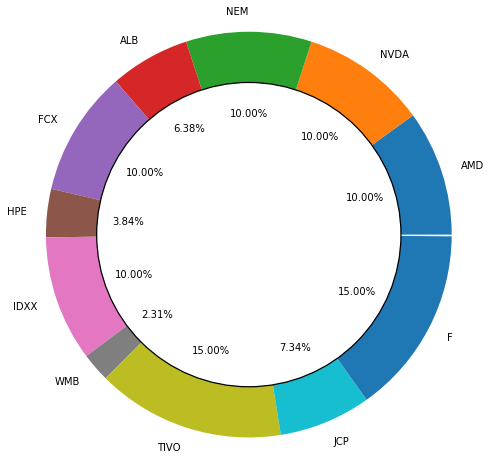

In [38]:
labels = newlist.index.values.tolist()
weights = newlist.tolist()
explode = (0,0,0,0,0,0,0,0,0,0,0)

plt.pie(weights,explode=explode, labels=labels, autopct='%.2f%%', shadow=False)
#Add a circle to give dougnut appearance 
circle = plt.Circle((0,0), 0.75, color='black', fc='white', linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(circle)
plt.axis('equal')
fig.set_size_inches(8,8)
plt.show()  



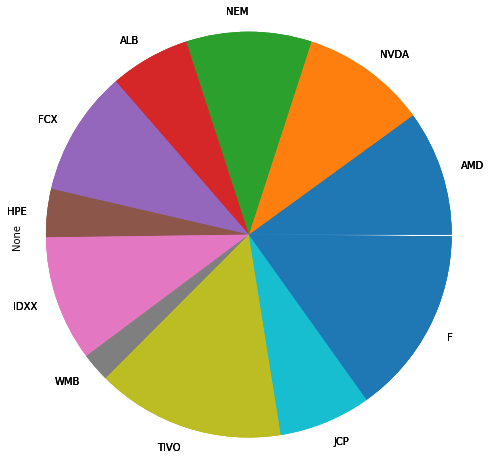

In [50]:
abs(newlist).plot.pie(y=None) 
plt.axis('equal')
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.show()

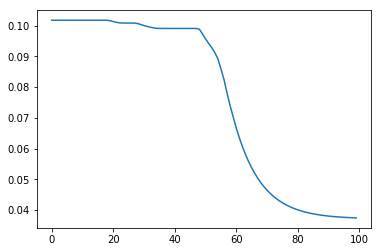

In [52]:
# mu zu rendite 

scale1 = [t for t in range(Scale)] 
#scale = scale.reverse()
rendite = np.array(exp_returns)*100

plt.plot(scale1,rendite)
plt.show()

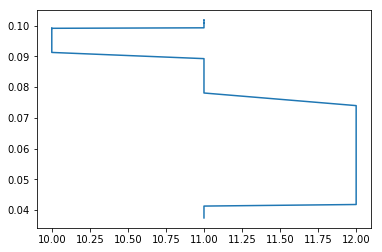

In [53]:
# relationship between number of assets in a portfolio (weighted more than 0.001) and expected return

def counting():
    count = []
    for lists in sublist:
        newlist = []
        for i in lists:
            if (i >= 0.005):
                newlist.append(i)
        count.append(len(newlist))
    return count
q = counting()

plt.plot(q, rendite)
plt.show()

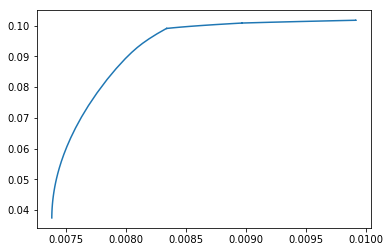

In [54]:
#classic markowitz bullet

plt.plot(exp_risk, rendite)
plt.show()

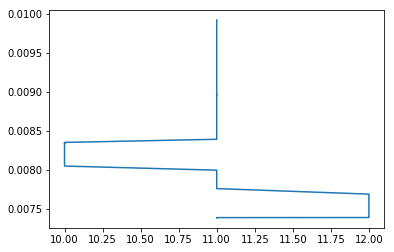

In [55]:
#risk and number of stocks in a portfolio
plt.plot(q, exp_risk)
plt.show()


In [51]:
## continue later